# Trabajando de forma conjunta con Python y con R.

Hoy vamos a ver como podemos juntar lo bueno de [R](http://cran.r-project.org/), algunas de sus librerías, con Python usando **rpy2**. 

Pero, lo primero de todo, ¿[qué es rpy2](http://rpy.sourceforge.net/)? rpy2 es una interfaz que permite que podamos comunicar información entre R y Python y que podamos acceder a funcionalidad de R desde Python. Por tanto, podemos estar usando Python para todo nuestro análisis y en el caso de que necesitemos alguna librería estadística especializada de R podremos acceder a la misma usando rpy2.

Para poder usar rpy2 necesitarás tener [instalado tanto Python (CPython versión >= 2.7.x) como R (versión >=3)](http://rpy.sourceforge.net/rpy2/doc-2.5/html/overview.html#requirements), además de las librerías R a las que quieras acceder. [Conda permite realizar todo el proceso de instalación de los intérpretes de Python y R, además de librerías](http://continuum.io/conda-for-R), pero no he trabajado con Conda y R por lo que no puedo aportar mucho más en este aspecto. Supongo que será parecido a lo que hacemos con Conda y Python.

Para este microtutorial voy a hacer uso de la librería **[extRemes](http://cran.r-project.org/web/packages/extRemes/index.html)** de R que permite hacer análisis de valores extremos usando varias de las metodologías más comúnmente aceptadas.

Como siempre, primero de todo, importaremos la funcionalidad que necesitamos para la ocasión.

In [1]:
# Importamos pandas y numpy para manejar los datos que pasaremos a R
import pandas as pd
import numpy as np

# Usamos rpy2 para interactuar con R
import rpy2.robjects as ro

# Activamos la conversión automática de tipos de rpy2
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

import matplotlib.pyplot as plt
%matplotlib inline

En el anterior código podemos ver una serie de cosas nuevas que voy a explicar brevemente:

* `import rpy2.robjects as ro`, esto lo explicaremos un poquito más abajo.
* `import rpy2.robjects.numpy2ri`, importamos el módulo numpy2ri. Este módulo permite que hagamos conversión automática de objetos numpy a objetos rpy2.
* `rpy2.robjects.numpy2ri.activate()`, hacemos uso de la función `activate` que activa la conversión automática de objetos que hemos comentado en la línea anterior.

# Brevísima introducción a algunas de las cosas más importantes de rpy2.

Para evaluar directamente código R podemos hacerlo usando `rpy2.robjects.r` con el código R expresado como una cadena (`rpy2.robjects` lo he importado como `ro` en este caso, como podéis ver más arriba):

In [2]:
codigo_r = """
saluda <- function(cadena) {
  return(paste("Hola, ", cadena))
}
"""
ro.r(codigo_r)

<SignatureTranslatedFunction - Python:0x03096490 / R:0x03723E98>

En la anterior celda hemos creado una función R llamada `saluda` y que ahora está disponible en el espacio de nombres global de R. Podemos acceder a la misma desde Python de la siguiente forma:

In [3]:
saluda_py = ro.globalenv['saluda']

Y podemos usarla de la siguiente forma:

In [4]:
res = saluda_py('pepe')
print(res[0])

Hola,  pepe


En la anterior celda véis que para acceder al resultado he tenido que usar `res[0]`. En realidad, lo que nos devuleve rpy2 es:

In [5]:
print(type(res))
print(res.shape)

<class 'numpy.ndarray'>
(1,)


En este caso un numpy array con diversa información del objeto rpy2. Como el objeto solo devuelve un string pues el numpy array solo tiene un elemento.

Podemos acceder al código R de la función de la siguiente forma:

In [6]:
print(saluda_py.r_repr())

function (cadena) 
{
    return(paste("Hola, ", cadena))
}


Hemos visto como acceder desde Python a nombres disponibles en el entorno global de R. ¿Cómo podemos hacer para que algo que creemos en Python este accesible en R?

In [7]:
variable_r_creada_desde_python = ro.FloatVector(np.arange(1,5,0.1))

Veamos como es esta `variable_r_creada_desde_python` dentro de Python

In [8]:
variable_r_creada_desde_python

<FloatVector - Python:0x09D5A7B0 / R:0x07FE8900>
[1.000000, 1.100000, 1.200000, ..., 4.700000, 4.800000, 4.900000]

¿Y lo que se tendría que ver en R?

In [9]:
print(variable_r_creada_desde_python.r_repr())

c(1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 
2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 
3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 
4.9)


Pero ahora mismo esa variable no está disponible desde R y no la podríamos usar dentro de código R que permanece en el espacio R (vaya lío, ¿no?)

In [10]:
ro.r('variable_r_creada_desde_python')

RRuntimeError: Error in eval(expr, envir, enclos) : 
  object 'variable_r_creada_desde_python' not found


Vale, tendremos que hacer que sea accesible desde R de la siguiente forma:

In [11]:
ro.globalenv["variable_ahora_en_r"] = variable_r_creada_desde_python
print(ro.r("variable_ahora_en_r"))

[ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9
  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9]


Ahora que ya la tenemos accesible la podemos usar desde R. Por ejemplo, vamos a usar la función `sum` en R que suma los elementos pero directamente desde R:

In [12]:
print(ro.r('sum(variable_ahora_en_r)'))
print(np.sum(variable_r_creada_desde_python))

[ 118.]
118.0


Perfecto, ya sabemos, de forma muy sencilla y básica, como podemos usar R desde Python, como podemos pasar información desde R hacia Python y desde Python hacia R. ¡¡¡Esto es muy poderoso!!!, estamos juntando lo mejor de dos mundos, la solidez de las herramientas científicas de Python con la funcionalidad especializada que nos pueden aportar algunas librerías de R no disponibles en otros ámbitos.

# Trabajando de forma híbrida entre Python y R

Vamos a empezar importando la librería *extRemes* de R:

In [13]:
# Importamos la librería extRemes de R
from rpy2.robjects.packages import importr
extremes = importr('extRemes')

En la anterior celda hemos hecho lo siguiente:

* `from rpy2.robjects.packages import importr`, La función `importr` nos servirá para importar las librerías R
* `extremes = importr('extRemes')`, de esta forma importamos la librería `extRemes` de R, sería equivalente a hacer en R `library(extRemes)`.

Leemos datos con pandas. En el mismo repo donde está este notebook está también un fichero de texto con datos que creé a priori. Supuestamente son datos horarios de velocidad del viento por lo que vamos a hacer análisis de valores extremos de velocidad del viento horaria.

In [15]:
data = pd.read_csv('datasets/Synthetic_data.txt',
                   sep = '\s*', skiprows = 1, parse_dates = [[0, 1]],
                   names = ['date','time','wspd'], index_col = 0)

In [16]:
data.head(3)

,wspd
date_time,
1983-01-01 00:00:00,7.9
1983-01-01 01:00:00,8.2
1983-01-01 02:00:00,8.5


Extraemos los máximos anuales los cuales usaremos posteriormente dentro de R para hacer cálculo de valores extremos usando la [distribución generalizada de valores extremos (GEV)](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution):

In [17]:
max_y = data.wspd.groupby(pd.TimeGrouper(freq = 'A')).max()

Dibujamos los valores máximos anuales usando Pandas:

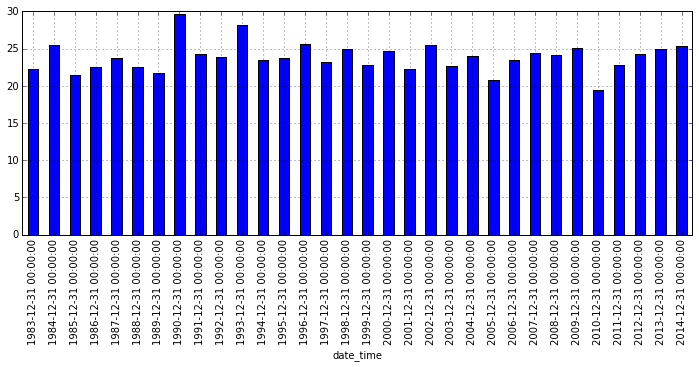

In [18]:
max_y.plot(kind = 'bar', figsize = (12, 4))

Referenciamos la funcionalidad [`fevd` (*fit extreme value distribution*) dentro del paquete `extremes`](http://cran.r-project.org/web/packages/extRemes/extRemes.pdf) de R para poder usarla directamente con los valores máximos que hemos obtenido usando Pandas y desde Python.

In [19]:
fevd = extremes.fevd

Como hemos comentado anteriormente, vamos a calcular los parámetros de la GEV usando el método de ajuste `GMLE` (*Generalised Maximum Lihelihood Estimation*) y los vamos a guardar directamente en una variable Python.

Veamos la ayuda antes:

In [20]:
print(fevd.__doc__)

Python representation of an R function.
description
-----------


 Fit a univariate extreme value distribution functions (e.g., GEV, GP, PP, Gumbel, or Exponential) to data; possibly with covariates in the parameters.
 


fevd(
    x,
    data,
    threshold = rinterface.NULL,
    threshold_fun = ~,
    location_fun = ~,
    scale_fun = ~,
    shape_fun = ~,
    use_phi = False,
    type = c,
    method = c,
    initial = rinterface.NULL,
    span,
    units = rinterface.NULL,
    time_units = days,
    period_basis = year,
    na_action = <rpy2.rinterface.SexpVector - Python:0x116D6C50 / R:0x0C4BB100>,
    optim_args = rinterface.NULL,
    priorFun = rinterface.NULL,
    priorParams = rinterface.NULL,
    proposalFun = rinterface.NULL,
    proposalParams = rinterface.NULL,
    iter = 9999.0,
    weights = 1.0,
    blocks = rinterface.NULL,
    verbose = False,
)

x :  `fevd`: `x` can be a numeric vector, the name of a column of `data` or a formula giving the data to which the EVD is t

Y ahora vamos a hacer un cálculo sin meternos mucho en todas las opciones posibles.

In [21]:
res = fevd(max_y.values, type = "GEV", method = "GMLE")

¿Qué estructura tiene la variable `res` que acabamos de crear y que tiene los resultados del ajuste?

In [22]:
print(type(res))

<class 'rpy2.robjects.vectors.ListVector'>


In [23]:
print(res.r_repr)

<bound method ListVector.r_repr of <ListVector - Python:0x10AB8878 / R:0x0CA9B458>
[Vector, ndarray, ndarray, ..., ndarray, ListV..., ListV...]
  call: <class 'rpy2.robjects.vectors.Vector'>
  <Vector - Python:0x10AB8418 / R:0x0CB2FFB4>
[RNULLType, Vector, Vector, Vector]
  data.name: <class 'numpy.ndarray'>
  array(['structure(c(22.2, 25.5, 21.5, 22.5, 23.7, 22.5, 21.7, 29.7, 24.2, ',
       '23.8, 28.1, 23.4, 23.7, 25.6, 23.2, 24.9, 22.8, 24.6, 22.3, 25.5, ',
       '22.6, 24, 20.8, 23.5, 24.4, 24.1, 25.1, 19.4, 22.8, 24.2, 25, ',
       '25.3), .Dim = 32L)', ''], 
      dtype='<U66')
  weights: <class 'numpy.ndarray'>
  array([ 1.])
  ...
  call: <class 'numpy.ndarray'>
  array(['location', 'scale', 'shape'], 
      dtype='<U8')
<ListVector - Python:0x10AB8878 / R:0x0CA9B458>
[Vector, ndarray, ndarray, ..., ndarray, ListV..., ListV...]
<ListVector - Python:0x10AB8878 / R:0x0CA9B458>
[Vector, ndarray, ndarray, ..., ndarray, ListV..., ListV...]>


Según nos indica lo anterior, ahora `res` es un vector que está compuesto de diferentes elementos. Los vectores pueden tener un nombre para todos o algunos de los elementos. Para acceder a estor nombres podemos hacer:

In [24]:
res.names

array(['call', 'data.name', 'weights', 'in.data', 'x', 'priorFun',
       'priorParams', 'method', 'type', 'period.basis', 'par.models',
       'const.loc', 'const.scale', 'const.shape', 'n', 'na.action',
       'parnames', 'results', 'initial.results'], 
      dtype='<U15')

Según el output anterior, parece que hay un nombre `results`, ahí es donde se guardan los valores del ajuste, los estimadores. Para acceder al mismo podemos hacerlo de diferentes formas. Con Python tendriamos que saber el índice y acceder de forma normal (`__getitem__()`). Existe una forma alternativa usando el método `rx` que nos permite acceder directamente con el nombre:

In [25]:
results = res.rx('results')

In [26]:
print(results.r_repr)

<bound method ListVector.r_repr of <ListVector - Python:0x10ABBCB0 / R:0x0CBFBC40>
[ListVector]
<ListVector - Python:0x10ABBCB0 / R:0x0CBFBC40>
[ListVector]>


Parece que tenemos un único elemento:

In [27]:
results = results[0]
results.r_repr

<bound method ListVector.r_repr of <ListVector - Python:0x10ABF490 / R:0x0C851BA0>
[ndarray, ndarray, ndarray, ..., RNULL..., ndarray, ListV...]
  par: <class 'numpy.ndarray'>
  array([ 23.06394152,   1.75769129,  -0.16288164])
  value: <class 'numpy.ndarray'>
  array([  1.00000000e+16])
  counts: <class 'numpy.ndarray'>
  array([1, 1], dtype=int32)
  ...
  par: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  value: <class 'numpy.ndarray'>
  array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])
<ListVector - Python:0x10ABF490 / R:0x0C851BA0>
[ndarray, ndarray, ndarray, ..., RNULL..., ndarray, ListV...]>

Vemos ahora que `results` tiene un elemento con nombre `par` donde se guardan los valores de los estimadores del ajuste a la GEV que hemos obtenido usando GMLE. Vamos a obtener finalmente los valores de los estimadores:

In [28]:
location, scale, shape = results.rx('par')[0][:]
print(location, scale, shape)

23.0639415199 1.75769128743 -0.162881636772


# Funcion mágica para R (antigua `rmagic`)

Usamos la antigua función mágica `rmagic` que ahora se activará en el notebook de la siguiente forma:

In [29]:
%load_ext rpy2.ipython

Veamos como funciona la functión mágica de R:

In [30]:
help(rpy2.ipython.rmagic.RMagics.R)

Help on function R in module rpy2.ipython.rmagic:

R(self, line, cell=None, local_ns=None)
    ::
    
      %R [-i INPUT] [-o OUTPUT] [-n] [-w WIDTH] [-h HEIGHT] [-p POINTSIZE]
             [-b BG] [--noisolation] [-u {px,in,cm,mm}] [-r RES]
             [code [code ...]]
    
    Execute code in R, optionally returning results to the Python runtime.
    
    In line mode, this will evaluate an expression and convert the returned
    value to a Python object.  The return value is determined by rpy2's
    behaviour of returning the result of evaluating the final expression.
    
    Multiple R expressions can be executed by joining them with semicolons::
    
        In [9]: %R X=c(1,4,5,7); sd(X); mean(X)
        Out[9]: array([ 4.25])
    
    In cell mode, this will run a block of R code. The resulting value
    is printed if it would printed be when evaluating the same code
    within a standard R REPL.
    
    Nothing is returned to python by default in cell mode::
    
        I

A veces, será más simple usar la función mágica para interactuar con R. Veamos un ejemplo donde le pasamos a R el valor obtenido de la función `fevd` del paquete `extRemes` de R que he usado anteriormente y corremos cierto código directamente desde R sin tener que usar `ro.r`.

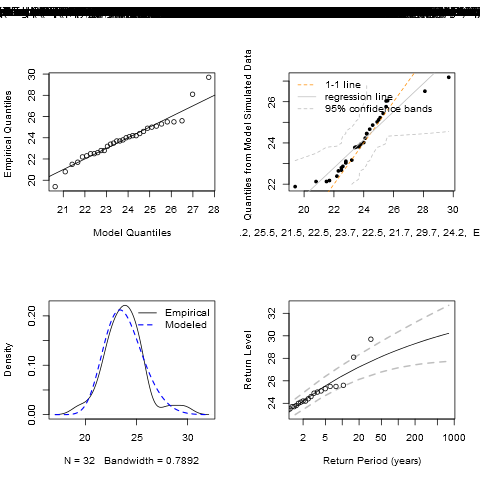

In [31]:
%R -i res plot.fevd(res)

En la anterior celda de código le he pasado como parámetro de entrada (`- i res`) la variable `res` que había obtenido anteriormente para que esté disponible desde R. y he ejecutado código R puro (`plot.fevd(res)`).

Si lo anterior lo quiero hacer con rpy2 puedo hacer lo siquiente:

<p class="alert alert-info">CUIDADO, la siguiente celda de código puede provocar que se reinicialice el notebook y se rompa la sesión. Si has hecho cambios en el notebook guárdalos antes de ejecutar la celda, por lo que pueda pasar...</p>

In [35]:
ro.globalenv['res'] = res
ro.r("plot.fevd(res)")

rpy2.rinterface.NULL

Lo anterior me bloquea el notebook y me 'rompe' la sesión ([en windows, al menos](https://bitbucket.org/rpy2/rpy2/issues?q=windows)) ya que la ventana de gráficos se abre de forma externa... Por tanto, una buena opción para trabajar de forma interactiva con Python y R de forma conjunta y que no se 'rompa' nada es usar tanto rpy2 como su extensión para el notebook de Jupyter (dejaremos de llamarlo IPython poco a poco).

# Usando Python y R combinando rpy2 y la función mágica

Vamos a combinar las dos formas de trabajar con rpy2 en el siguiente ejemplo:

In [32]:
metodos = ["MLE", "GMLE"]
tipos = ["GEV", "Gumbel"]

Lo que vamos a hacer es calcular los parámetros del ajuste usando la distribución GEV y Gumbel, que es un caso especial de la GEV. El ajuste lo calculamos usando tanto MLE como GMLE. Además de mostrar los valores resultantes del ajuste para los estimadores vamos a mostrar el dibujo de cada uno de los ajustes y algunos test de bondad. Usamos Python para toda la maquinaria de los bucles, usamos rpy2 para obtener los estimadores y usamos la función mágica de rpy2 para mostrar los gráficos del resultado.

tipo de ajuste:  GEV
método de ajuste:  MLE
[ 23.05170779   1.80858528  -0.14979836]


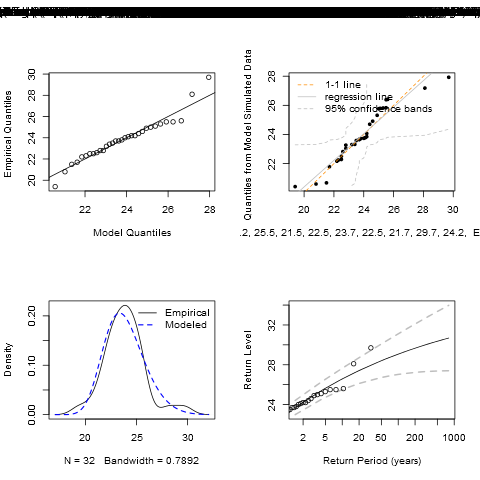

tipo de ajuste:  GEV
método de ajuste:  GMLE
[ 23.06394152   1.75769129  -0.16288164]


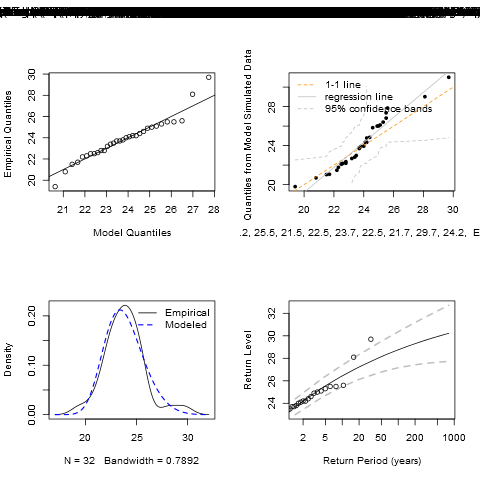

tipo de ajuste:  Gumbel
método de ajuste:  MLE
[ 22.90587606   1.81445179]


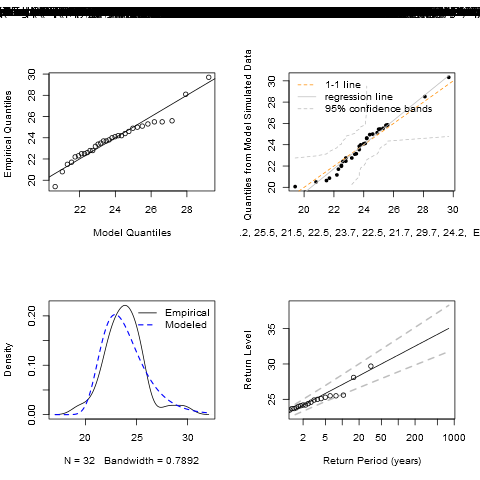

tipo de ajuste:  Gumbel
método de ajuste:  GMLE
[ 22.90587606   1.81445179]


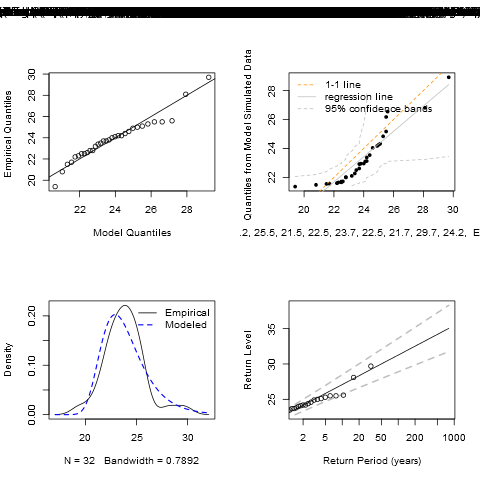

In [33]:
for t in tipos:
    for m in metodos:
        print('tipo de ajuste: ', t)
        print('método de ajuste: ', m)
        res = fevd(max_y.values, method = m, type = t)
        if m == "Bayesian":
            print(res.rx('results')[0][-1][0:-2])
        elif m == "Lmoments":
            print(res.rx('results')[0])
        else:
            print(res.rx('results')[0].rx('par')[0][:])
        %R -i res plot.fevd(res)

# Comentarios finales

Espero que este microtutorial os valga, al menos, para conocer rpy2 y la potencia que os puede llegar a aportar a vuestros análisis 'pythónicos'. Como resumen:

* Tenemos en nuestras manos una herramienta muy poderosa.
* Rpy2 puede estar poco madura en algún aspecto aunque ha mejorado bastante con respecto a alguna versión de rpy2 que usé anteriormente.
* También podéis usar directamente [R como kernel](https://github.com/IRkernel/IRkernel), aunque perdéis la interacción con Python. También puede ocurrir que la instalación os haga perder mucho el tiempo [para poder hacerlo funcionar](https://github.com/IRkernel/IRkernel/issues/54) si os veis obligados a usarlo desde windows.
* En la elaboración de este microtutorial la consola de R donde iba haciendo algunas pruebas simples se me ha 'roto' muchísimas más veces de las que consideraría aceptables. No se puede quedar colgada, cerrar,..., seis o siete veces en media hora una consola haciendo cosas simples. Eso hace que si quieres usar R de forma interactiva debas usar alternativas como Jupyter, RStudio u otros que desconozco ya que la consola oficial no está 'ni pa pipas' (por lo menos en Windows, el sistema operativo con más usuarios potenciales, mal que me pese).
* Sigo manteniendo muchas reservas respecto a R como Lenguaje de Programación (en mayúsculas) por lo que si puedo limitar su uso a alguna librería especializada que necesito y a la que pueda acceder con rpy2 es lo que seguiré haciendo (*[If you are using R and you think you're in hell, this is a map for you](http://www.burns-stat.com/pages/Tutor/R_inferno.pdf).*)